# Refrigeration Cycle Simulations

This notebook demonstrates the simulation framework developed in [1] using two examples of refrigeration cycles. The first example focuses on simulating a one-stage refrigeration cycle that utilizes R134a as the refrigerant. The second example involves simulating a CO2/R134a Cascade cycle, which is more complex compared to the first example.

## One Stage DX Cycle Simulation

The initial simulation focuses on a one-stage R134a refrigeration cycle comprising a compressor, condenser, expansion valve, and evaporator. The compressor, a semi-hermetic reciprocating type, operates at a speed of 1450 rpm and delivers a volume flow rate of 41.33 m³/h. It consumes 4.68 kW of power under nominal conditions. The compressor is modeled as a pressure-based component using a compressor polynomial map:

$ y = c_1 + c_2T_v + c_3T_c + c_4T_v^2 + c_5T_vT_c + c_6T_c^2 + c_7T_v^3 + c_8T_vT_c^2 + c_9T_vT_c^2 + c_{10}T_vT_c^3$

Here, the output variable $y$ represents the mass flow rate $\dot{m}$ in kg/h and the absorbed compressor power $P_{co}$ in kW, both depending on the evaporating temperature $T_v$ and the condensing temperature $T_c$. The compressor coefficients $c_1, c_2...c_{10}$ required for the calculation can be obtained from the compressor manufacturer's freely available software [1].

The evaporation and condensation processes occur within plate heat exchangers with heat transfer areas of 2.64 m² and 3.65 m², respectively. The evaporator uses air as the cooling medium, while the condenser employs water as the heat transfer medium.

For the evaporator and condenser, a mass flow-based component approach known as the Moving-Boundary Model [2] is employed. This model considers heat transfer and pressure loss coefficients for each phase within the condenser, determined by correlations from [3], and for the evaporator, determined by correlations from [4].

The expansion valves are pressure-based components implemented using a Fixed Orifice Model. The mass flow rates at the input and output ports are calculated as:

$\dot{m}_{i,ev} = \dot{m}_{o,ev} = C_f\sqrt{\rho(p_{i,ev} − p_{o,ev})}$.

Here, $C_f$ represents a constant flow coefficient characterizing the valve. Moreover, an isenthalpic expansion assumption is made, resulting in the equality:

$h_{i,ev} = h_{o,ev}$.

In this specific case, the components are modeled as either pressure-based or mass flow-based components. Pressure-based components require input variables such as inlets and outlets pressure values $p_i$ and $p_o$ and inlets enthalpy $h_i$. Output variables include inlets and outlets mass flow rates $\dot{m}_i$ and $\dot{m}_o$ as well as specific enthalpy $h_i$ at the inlet of the component. A mass flow-based component requires as inputs pressure values $p_i$, specific enthalpies $h_i$ and mass flow rates $m_i$ at the inlets of the component. The output variables are the pressure $p_o$ values, specific enthalpies $h_o$ and mass flow rates $m_o$ at all outlets of the component.

The following figure shows the scheme of the One Stage DX cycle including the tearing-, boundary condition-, and system variables.

![fig](./Cycles/OneStageDX/Circuit_OneStageDX.svg)

### Junction Port Connectivity Matrix (JPCM ) representing One Stage DX Cycle
Each component of a cycle has in- and output _ports_ representing its physical in- and outlets. These ports contain all 
the information needed to solve the system-equations. Numerical _junctions_ describe how the in- and output ports of 
the components are connected to each other. At a junction, the pressure of all connecting ports must be equal and the 
stationary mass and energy conservation equations must be satisfied. Which ports are connected to which junctions, is specified in the 
_Junction-Port-Connectivity-Matrix_ (JPCM). The rows of the JPCM correspond to the junctions, and the columns to the components.

The JPCM representing the One Stage DX cycle is presented below.. Looking at the compressor column of the JPCM, we can see that this component is connected to junction 1 by a regular input port and to junction 2 by a regular output port, meaning that the compressor receives information of junction 1 with which the compressor model is being solved and gives its output informationto junction 2. Equally, the expansion valve receives information from junction 3 and gives information to junction 4. The condenser and evaporator each have ports for their hot- and cold-side. The hot side of the condenser receives information from junction 2 and gives information to junction 3. Its cold side is connected to junctions 5 and 6, we can see that these junctions are part of fluid loop 2, that junction 5 is a source (1) and junction 6 a sink (-1). In the scheme we only see _Source_- and _Sink_-tags that "hide" the numbers of the junctions. Equally for the evaporator, the only difference naturally being that the hot side is connected to the second open fluid loop and the cold side to the closed fluid loop. 

The equations necessary to solve the system are being created at the junctions based on the JPCM.

|  | Compressor | Condenser | Expansion Valve | Evaporator | Fluid Loop | Source / Sink |
|----------------------|------------|-----------|-----------------|------------|------------|---------------|
| Junction 1           | p          | 0         | 0               | -c         | 1          | 0             |
| Junction 2           | -p         | h         | 0               | 0          | 1          | 0             |
| Junction 3           | 0          | -h        | p               | 0          | 1          | 0             |
| Junction 4           | 0          | 0         | -p              | c          | 1          | 0             |
| Junction 5           | 0          | c         | 0               | 0          | 2          | 1             |
| Junction 6           | 0          | -c        | 0               | 0          | 2          | -1            |
| Junction 7           | 0          | 0         | 0               | h          | 3          | 1             |
| Junction 8           | 0          | 0         | 0               | -h         | 3          | -1            |

The entries of the matrix are the ports connecting component and junction. The ports can be one of two types. If the port 
in a cell is positive, it is an input port (with respect to the component), if it is negative, it is an output port. 
Also, there are different specifications of ports: regular ports, heat exchanger hot side ports, heat exchager cold side ports.
All current possibilities are summarized in the following table:

| Port                                 | Letter code |
|:-------------------------------------|:-----------:|
| Regulat input port                   |      p      |
| Regular output port                  |     -p      |
| Heat Exchanger hot side input port   |      h      |
| Heat Exchanger hot side output port  |     -h      |
| Heat Exchanger cold side input port  |      c      |
| Heat Exchanger cold side output port |     -c      |

### Generating One Stage DX system components and equations corresponding to JPCM
The code snippet loads the JPCM for a one-stage R134a refrigeration cycle from a CSV file and initializes it as a list. It also defines lists for the solver path and boundary types of the components. The component types, solver paths, boundary types, and fluids for each component are specified. Components are created based on the defined parameters, and the corresponding fluids are assigned to each port. The Tripartite Graph of the system is generated using the JPCM. Finally, a tearing algorithm is executed to identify tearing variables `Vt`, create an execution list `exec_list`, determine the residual equation `res_equa`, and calculate the necessity and number of design equations `design_equa`, based on the Tripartite Graph.

In that case the tearing algorithm identifies the tearing variables $p_{i,co}$, $h_{i,co}$ and $p_{o,co}$ and $p_{o,ev}$ and residual equations:

1. $h_{i_co} - h_{o, v} = 0$

2. $p_{i_co} - p_{o,v} = 0$

3. $\dot{m}_{i,ev} -\dot{m}_{o,c} = 0$.

These equations represent the energy balance and pressure equality at junction 1 and the mass balance at junction 3. However, to fully close the system of equations, one more design equation is required. This additional design equation is necessary to provide sufficient constraints and determine the remaining unknowns in the system.

### System Simulation Class, Function and Module Imports

The code imports various modules and functions needed for the system simulation. These include `Component`, `PressureBasedComponent`, `MassFlowBasedComponent`, `BypassComponent`, `BalanceEquation`, `EnthalpyFlowBalance`, `SuperheatEquation`, `SubcoolingEquation`, `TripartiteGraph`, `tearing_alg`, `system_solver`, `logph`, `psd`, `set_bc_values_onestage`, `set_dc_values_onestage`, `set_bc_values_cascade`, `set_dc_values_cascade`.

Additional imports include `os`, `csv`, `codecs` for file handling, `PropsSI` from the CoolProp library for thermodynamic property calculations, `ipywidgets` for creating interactive widgets, and `display` from IPython.display for visualizing the widgets.

In [1]:
from system import Component, PressureBasedComponent, MassFlowBasedComponent, BypassComponent,\
                   BalanceEquation, EnthalpyFlowBalance, SuperheatEquation, SubcoolingEquation,\
                   TripartiteGraph, tearing_alg, system_solver, logph, psd, set_bc_values_onestage, \
                   set_dc_values_onestage, set_bc_values_cascade, set_dc_values_cascade
                    
import os
import csv
import codecs
from CoolProp.CoolProp import PropsSI
import ipywidgets as wd
from IPython.display import display

### Generating One Stage DX system components and equations corresponding to JPCM
The code snippet loads the JPCM for a one-stage R134a refrigeration cycle from a CSV file and initializes it as a list. It also defines lists for the solver path and boundary types of the components. The component types, solver paths, boundary types, and fluids for each component are specified. Components are created based on the defined parameters, and the corresponding fluids are assigned to each port. The Tripartite Graph of the system is generated using the JPCM. Finally, a tearing algorithm is executed to identify tearing variables `Vt`, create an execution list `exec_list`, determine the residual equation `res_equa`, and calculate the necessity and number of design equations `design_equa`, based on the Tripartite Graph.

In that case the tearing algorithm identifies the tearing variables $p_{i,co}$, $h_{i,co}$ and $p_{o,co}$ and $p_{o,ev}$ and residual equations:

1. $h_{i_co} - h_{o, v} = 0$

2. $p_{i_co} - p_{o,v} = 0$

3. $\dot{m}_{i,ev} -\dot{m}_{o,c} = 0$.

These equations represent the energy balance and pressure equality at junction 1 and the mass balance at junction 3. However, to fully close the system of equations, one more design equation is required. This additional design equation is necessary to provide sufficient constraints and determine the remaining unknowns in the system.

In [2]:
# loads and generates JPCM from .csv-file
directory = os.getcwd()
file = codecs.open(directory + '/Cycles/OneStageDX/JPCM.csv', 'r', encoding='utf-8-sig')
csv_file = csv.reader(file, delimiter=';')
jpcm, component_typ_list, boundary_typ_list =  [], [], []
for i, line in enumerate(csv_file):
    if i > 0:
        jpcm.append(line[1:])
for i, line in enumerate(jpcm):
    for j, item in enumerate(line):
        jpcm[i][j] = int(item)

# defines component types of the cycle
component_typ_list = ['Compressor', 'Condenser', 'Expansion Valve', 'Evaporator']

components_name_list = component_typ_list.copy()

# defines the solver path of each component
solver_path_list = [directory + '/Cycles/OneStageDX/Components/Compressor/Polynomial based Model',
                    directory + '/Cycles/OneStageDX/Components/Condenser/Moving Boundary Model',
                    directory + '/Cycles/OneStageDX/Components/ExpansionValve',
                    directory + '/Cycles/OneStageDX/Components/Evaporator/Moving Boundary Model']

# defines boundary type of each component
boundary_typ_list = ['PressureBasedComponent', 'MassFlowBasedComponent', 'PressureBasedComponent', 'MassFlowBasedComponent']


# defines fluids of each fluid loop
fluid_list = ['R134a', 'Air', 'Water']

# generates components and sets corresponding fluid to each port
components = []
for i, item in enumerate(component_typ_list):
    if boundary_typ_list[i] == 'PressureBasedComponent':
        components.append(PressureBasedComponent(i+1, item, components_name_list[i], jpcm))
    elif boundary_typ_list[i] == 'MassFlowBasedComponent':
        components.append(MassFlowBasedComponent(i+1, item, components_name_list[i], jpcm))
    elif boundary_typ_list[i] == 'BypassComponent':
        components.append(BypassComponent(i + 1, item, components_name_list[i], jpcm))
    for port in components[i].ports:
        port.fluid = fluid_list[port.port_id[-2]-1]
    components[i].solver_path = solver_path_list[i]

# generates the systems Tripartite Graph from JPCM
tpg = TripartiteGraph(jpcm, components)

# runs tearing algorithm to identify tearing variable, execution list, residual equation and the necessity and number of
# design equations
Vt, exec_list, res_equa, design_equa = tearing_alg(tpg)

### Setting One Stage DX system boundary conditions and design criterias
The code snippet defines the boundary conditions and design criteria for the refrigeration cycle. The boundary conditions include the inlet temperature ($T_{i,c,so}$ and $T_{i,v,so}$), inlet pressure ($p_{i,c,so}$ and $p_{i,v,so}$), and mass flow rate ($\dot{m}_{i,c,so}$ and $\dot{m}_{i,v,so}$) for the condenser and evaporator on their secondary side. The design criteria specify the desired superheat `DC_SH` in the evaporator.

The boundary conditions are then set for the corresponding components in the system. For the evaporator, the inlet pressure, enthalpy, and mass flow rate are assigned. Similarly, for the condenser, the inlet pressure, enthalpy, and mass flow rate are set.

The code also defines scale factors for the solver and initial values for the variables that will be solved. The initial values include the compressor inlet pressure, enthalpy, and the outlet pressures for the condenser and evaporator.

These values will be used as starting points for the solver to find the solution to the refrigeration cycle.

In [3]:
# interactive-widget for additional accessing of boundary values
wid_BC_onestage = wd.interactive(set_bc_values_onestage, pi_v_so=(0.5,3.0,0.1), Ti_v_so=(-20,0,0.1), mi_v_so=(1.0,10.0,0.1),
                    pi_c_so=(0.5,3.0,0.1), Ti_c_so=(20,40,0.1), mi_c_so=(1.0,10.0,0.1))

print('Boundary condition values:')
display(wid_BC_onestage)

# interactive-widget for additional accessing of design criteria
wid_DC_onestage = wd.interactive(set_dc_values_onestage, SH_v=(0.0,20.0,0.1))
print('Design criteria values:')
display(wid_DC_onestage)

Boundary condition values:


interactive(children=(FloatSlider(value=1.0, description='pi_v_so', max=3.0, min=0.5), FloatSlider(value=-10.0…

Design criteria values:


interactive(children=(FloatSlider(value=5.0, description='SH_v', max=20.0), Output()), _dom_classes=('widget-i…

In [4]:
# gets boundary condition values from widget input
bc_values_onestage = wid_BC_onestage.kwargs

pi_v_so = bc_values_onestage['pi_v_so']
Ti_v_so = bc_values_onestage['Ti_v_so']
mi_v_so = bc_values_onestage['mi_v_so']

pi_c_so = bc_values_onestage['pi_c_so']
Ti_c_so = bc_values_onestage['Ti_c_so']
mi_c_so = bc_values_onestage['mi_c_so']

# gets design criteria value from widget input
dc_values_onestage = wid_DC_onestage.kwargs
SH_v = dc_values_onestage['SH_v']

# sets boundary condition values to corresponding components
for i, c in enumerate(components):
    if c.component_typ == 'Evaporator':
        for port in c.ports:
            if port.port_id[-1] == 1:
                port.p.set_value(pi_v_so * 1e5)
                port.h.set_value(PropsSI('H', 'P', pi_v_so * 1e5, 'T', Ti_v_so + 273.15, port.fluid))
                port.m.set_value(mi_v_so)
    elif c.component_typ == 'Condenser':
        for port in c.ports:
            if port.port_id[-1] == 1:
                port.p.set_value(pi_c_so * 1e5)
                port.h.set_value(PropsSI('H', 'P', pi_c_so * 1e5, 'T', Ti_c_so + 273.15, port.fluid))
                port.m.set_value(mi_c_so)
                
# generates superheat design equation and sets evaporator superheat value                 
design_equa = [SuperheatEquation(components[3], SH_v, 'out', 'h', psd['-c'])]
                
# solver scale factors
scale_factors = [1e-5, 1e-5, 10]

# solver initial values
pi_co0 = PropsSI('P', 'T', Ti_v_so + 273.15 - 5, 'Q', 1.0, fluid_list[Vt[1].port_id[-2]-1])
hi_co0 = PropsSI('H', 'P', pi_co0, 'Q', 1.0, fluid_list[Vt[1].port_id[-2]-1])
po_co0 = PropsSI('P', 'T', Ti_c_so + 273.15 + 5, 'Q', 1.0, fluid_list[Vt[1].port_id[-2]-1])
po_ev0 = pi_co0
x0 = [pi_co0, hi_co0, po_co0, po_ev0]

### Solving One Stage DX system and plotting results

The provided code snippet accomplishes the following tasks:

1. Resetting component ports by calling the `reset()` method on each component and setting the `linearized` attribute to `False`.

2. Running the system solver to solve the system of equations of the cycle by invoking the `system_solver()` function with appropriate parameters and storing the result in the `sol` variable.

3. Extracting the solution vector from `sol['x']` and assigning it to the `x` variable.

4. Solving and executing system equations and components by updating the component ports with the junction values corresponding to the solution. This involves iterating over the tearing variables and setting the values of pressure, enthalpy, and mass flow rate based on the tearing variable type and scale factors. Then, the system equations and components are solved and executed.

5. Extracting and storing junction values, including pressure, enthalpy, and temperature, from specific component ports.

6. Plotting a log-ph diagram using the `logph()` function with enthalpy and pressure values for a specific fluid.

7. Printing the junction values in a tabular format, including the junction number, pressure, enthalpy, and temperature.

8. Resetting all component ports by calling the `reset()` method on each component.

In summary, the code performs system solving, updates component ports, extracts and displays junction values, plots a log-ph diagram, and resets component ports.

Start Broyden Solver
computing Jacobian...
Iteration 1 / Max-Norm of Residuals: 0.03891320524091399
Iteration 2 / Max-Norm of Residuals: 0.023227809561984326
Iteration 3 / Max-Norm of Residuals: 0.011581262043476164
Iteration 4 / Max-Norm of Residuals: 0.008068394050049247
Iteration 5 / Max-Norm of Residuals: 0.0010247307648544666
Iteration 6 / Max-Norm of Residuals: 0.0003960994947460131
Iteration 7 / Max-Norm of Residuals: 7.399557803291828e-06
Iteration 8 / Max-Norm of Residuals: 1.9260868895798924e-07
Iteration 9 / Max-Norm of Residuals: 3.3070644713006917e-09
Iteration 10 / Max-Norm of Residuals: 3.5886303521692756e-10
Iteration 11 / Max-Norm of Residuals: 9.221789998292707e-14
Broyden Solver converged!


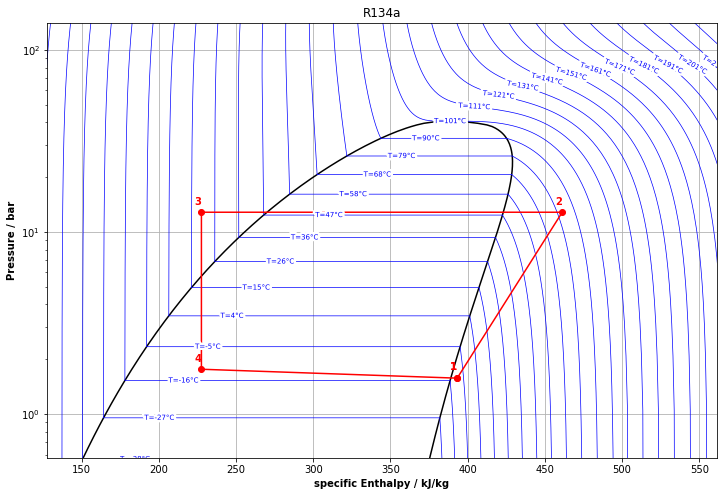

Junction 1:  p = 1.576 bar, h = 393.192 kJ/k, T = -10.957 °C, m = 0.037 kg/s
Junction 2:  p = 12.838 bar, h = 461.246 kJ/K, T = 82.732 °C, m = 0.037 kg/s
Junction 3:  p = 12.838 bar, h = 227.531 kJ/K, T = 20.0 °C, m = 0.037 kg/s
Junction 4:  p = 1.763 bar, h = 227.531 kJ/K, T = -13.218 °C, m = 0.037 kg/s


In [5]:
# resets all compontent ports
[(component.reset(), setattr(component, 'linearized', False)) for component in components]

# runs the system solver to solve the system of equations of th cycle
sol = system_solver(x0, Vt, components, exec_list, res_equa, design_equa, scale_factors)

# solution vector of tearing variables
x = sol['x']

if not sol['converged']:
    print(sol['message'])

else:
    # solves and exectutes all system equations and components to set all component ports by its junction value corresponding
    # to the solution
    for j, variable in enumerate(Vt):
        if variable.var_typ == 'p':
            variable.set_value(x[j] / scale_factors[0])
        elif variable.var_typ == 'h':
            variable.set_value(x[j] / scale_factors[1])
        elif variable.var_typ == 'm':
            variable.set_value(x[j] / scale_factors[2])
    for item in exec_list:
        if isinstance(item, BalanceEquation) or isinstance(item, EnthalpyFlowBalance):
            item.solve()
        elif isinstance(item, Component):
            item.solve()

    # junction values corresponding to the solution
    pi_co, hi_co, mi_co  = components[0].ports[0].p.value, components[0].ports[0].h.value, components[0].ports[0].m.value
    pi_c,  hi_c, mi_c   = components[1].ports[0].p.value, components[1].ports[0].h.value, components[1].ports[0].m.value
    pi_ev, hi_ev, mi_ev  = components[2].ports[0].p.value, components[2].ports[0].h.value, components[2].ports[0].m.value
    pi_v,  hi_v, mi_v   = components[3].ports[1].p.value, components[3].ports[1].h.value, components[3].ports[1].m.value
    Ti_co = PropsSI('T', 'P', pi_co, 'H', hi_co, fluid_list[0]) - 273.15
    Ti_c  = PropsSI('T', 'P', pi_c, 'H', hi_c, fluid_list[0]) - 273.15
    Ti_ev = PropsSI('T', 'P', pi_ev, 'H', hi_ev, fluid_list[0]) - 273.15
    Ti_v  = PropsSI('T', 'P', pi_v, 'H', hi_v, fluid_list[0]) - 273.15

    # plots log ph diagramm
    logph([[hi_co * 1e-3, hi_c * 1e-3, hi_ev * 1e-3, hi_v * 1e-3, hi_co * 1e-3]],
          [[pi_co * 1e-5, pi_c * 1e-5, pi_ev * 1e-5, pi_v * 1e-5, pi_co * 1e-5]],
          [[1, 2, 3, 4, 1]],
          [fluid_list[0]])

    print(f'Junction 1:  p = {round(pi_co/1e5, 3)} bar, h = {round(hi_co/1e3, 3)} kJ/k, T = {round(Ti_co, 3)} °C, m = {round(mi_co, 3)} kg/s')
    print(f'Junction 2:  p = {round(pi_c/1e5, 3)} bar, h = {round(hi_c/1e3, 3)} kJ/K, T = {round(Ti_c, 3)} °C, m = {round(mi_c, 3)} kg/s')
    print(f'Junction 3:  p = {round(pi_ev/1e5, 3)} bar, h = {round(hi_ev/1e3, 3)} kJ/K, T = {round(Ti_ev, 3)} °C, m = {round(mi_ev, 3)} kg/s')
    print(f'Junction 4:  p = {round(pi_v/1e5, 3)} bar, h = {round(hi_v/1e3, 3)} kJ/K, T = {round(Ti_v, 3)} °C, m = {round(mi_v, 3)} kg/s')


## CO$_2$/R134a Cascade Simulation

In the second case, an indirect two-stage or cascade system is simulated. It consists of two single-stage cycles that are thermally coupled using two cascade heat exchangers. These heat exchangers operate in parallel, serving as the evaporator for the high-temperature (HT) cycle and the condenser for the low-temperature (LT) cycle. CO$_2$ is used as the refrigerant in the LT cycle, while R134a is used in the HT cycle. This configuration enables efficient heat transfer and temperature control between the two cycles.

To model the compressors, compressor polynomial maps were employed, and their coefficients were determined using software provided by the compressor manufacturer. The evaporator in the CO$_2$ (LT) cycle and the condenser in the R134a (HT) cycle were modeled using the Moving-Boundary approach. As phase change occurs on both sides of the cascade heat exchangers, a coupled Moving-Boundary and Finite Volume model was used to model them. This model divides the phase regions determined by the Moving-Boundary algorithm into multiple finite volumes to enhance accuracy. Heat transfer within these volumes is calculated based on local state variables and material properties. The heat transfer and pressure loss coefficients on the CO$_2$ side were determined using correlations from reference [5].

The expansion valves were implemented as pressure-based components using a Fixed Orifice Model like in the first case.

The gas cooler was modeled using the ε-NTU method, while the two separators were implemented as MassFlowBased components. The outlet variables $p_{o,sep}$, $h_{o,sep}$, and $\dot{m}_{o,sep}$ for the separators are given by

$p_{o,sep} = p_{i,sep}$

$h_{o,sep} =  h_s(p_{i,sep}) \text{ if }\ h_{i,sep} > h_s(p_{i,sep}) \text{  else  } h_{o,sep} = h_{i,sep}$

$\dot{m}_{o,sep} = \dot{m}_{i,sep}$

The following figure shows the scheme of the CO$_2$/R134a Cascade cycle including the tearing-, boundary condition- and system variables.

![fig](./Cycles/R134a_CO2_Cascade/Circuit_CO2_R134a_Cascade.svg)

### JPCM representation of CO$_2$/R134a Cascade

|            | Compressor LT | Cas cooler | Cascade-HX 1 | Cascade-HX 2 | Separator LT | EV 1      | Evaporator |
|------------|---------------|------------|--------------|--------------|--------------|-----------|------------|
| Junction 1 | p             | 0          | 0            | 0            |      0       | 0         | -c         |
| Junction 2 | -p            | h          | 0            | 0            |      0       | 0         | 0          |
| Junction 3 | 0             | -h         | h            | h            |      0       | 0         | 0          |
| Junction 4 | 0             | 0          | -h           | -h           |      p       | 0         | 0          |
| Junction 5 | 0             | 0          | 0            | 0            |      -p      | p         | 0          |
| Junction 6 | 0             | 0          | 0            | 0            |      0       | -p        | c          |
| Junction 7 | 0             | 0          | -c           | -c           |      0       | 0         | 0          |
| Junction 9 | 0             | 0          | 0            | 0            |      0       | 0         | 0          |
| Junction 10| 0             | 0          | 0            | 0            |      0       | 0         | 0          |
| Junction 11| 0             | 0          | c            | 0            |      0       | 0         | 0          |
| Junction 12| 0             | 0          | 0            | c            |      0       | 0         | 0          |
| Source 1   | 0             | c          | 0            | 0            |      0       | 0         | 0          |
| Sink 1     | 0             | -c         | 0            | 0            |      0       | 0         | 0          |
| Source 2   | 0             | 0          | 0            | 0            |      0       | 0         | h          |
| Sink 2     | 0             | 0          | 0            | 0            |      0       | 0         | -h         |
| Source 3   | 0             | 0          | 0            | 0            |      0       | 0         | 0          |
| Sink 3     | 0             | 0          | 0            | 0            |      0       | 0         | 0          |

Compressor HT | Condenser | Separator HT | EV 2 | EV 3   | Fluid Loop | Source/Sink |
--------------|-----------|--------------|------|--------|------------|-------------|
 0            | 0         | 0            | 0    | 0      | 1          | 0           |
 0            | 0         | 0            | 0    | 0      | 1          | 0           |
 0            | 0         | 0            | 0    | 0      | 1          | 0           |
 0            | 0         | 0            | 0    | 0      | 1          | 0           |
 0            | 0         | 0            | 0    | 0      | 1          | 0           |
 0            | 0         | 0            | 0    | 0      | 1          | 0           |
 p            | 0         | 0            | 0    | 0      | 2          | 0           |
 -p           | h         | 0            | 0    | 0      | 2          | 0           |
 0            | -h        | p            | 0    | 0      | 2          | 0           |
 0            | 0         | -p           | p    | p      | 2          | 0           |
 0            | 0         | 0            | -p   | 0      | 2          | 0           |
 0            | 0         | 0            | 0    | -p     | 2          | 0           |
 0            | 0         | 0            | 0    | 0      | 3          | 1           |
 0            | 0         | 0            | 0    | 0      | 3          | -1          |
 0            | 0         | 0            | 0    | 0      | 4          | 1           |
 0            | 0         | 0            | 0    | 0      | 4          | -1          |
 0            | c         | 0            | 0    | 0      | 5          | 1           |
 0            | -c        | 0            | 0    | 0      | 5          | -1          |
 
 ### Generating CO$_2$/R134a Casade system components and equations corresponding to JPCM

The code snippet loads the JPCM for a cascade refrigeration system using R134a and CO2 as working fluids from a CSV file. The JPCM data is read and processed, and the necessary information is stored in lists. The component types, names, solver paths, and boundary types are defined in separate lists.

The code then generates the components based on the defined parameters. The appropriate fluid is assigned to each port of the component. The Tripartite Graph is created using the JPCM data to represent the connections between components and tearing variables.

Next, the tearing algorithm is executed to identify the tearing variables `Vt`, create an execution list `exec_list`, determine the residual equation `res_equa`, and calculate the necessity and number of design equations `design_equa` based on the Tripartite Graph.

The tearing algorithm identifies the tearing variables $p_{i,co,LT}$, $h_{i,co,LT}$, $p_{o,co,LT}$, $p_{i,co,HT}$, $h_{i,co,HT}$, $p_{o,co,HT}$, $p_{o,ev1}$, $p_{o,ev2}$, $p_{o,ev3}$ and $\dot{m}_{i,chx1}$. The residual equations are as follows:

Mass balance equations:

1. $\dot{m}_{o,chx1,h} + \dot{m}_{o,chx2,h} - \dot{m}_{i,sep,LT} = 0$
2. $\dot{m}_{o,sep,LT} - \dot{m}_{i,ev1} = 0$

Pressure equality equations: 

3. $p_{o,chx1,c} - p_{o,chx2,c} = 0$
4. $p_{i,co,HT} - p_{o,chx1,c} = 0$
5. $p_{i,co,LT} - p_{o,v,c} = 0$

Energy balance equations: 

6. $(\dot{m}h)_{o,chx1,h} + (\dot{m}h)_{o,chx2,h} - (\dot{m}h)_{i,sep,LT} = 0$
7. $h_{o,v,c} - h_{i,co,LT} = 0$

However, to fully close the system of equations and determine all the unknowns, three more design equations are required.

In [6]:
# loads and generates JPCM from .csv-file
directory = os.getcwd()
file = codecs.open(directory + '/Cycles/R134a_CO2_Cascade/JPCM.csv', 'r', encoding='utf-8-sig')
csv_file = csv.reader(file, delimiter=';')
jpcm, component_typ_list, boundary_typ_list = [], [], []
for i, line in enumerate(csv_file):
    if i > 0:
        jpcm.append(line[1:])
for i, line in enumerate(jpcm):
    for j, item in enumerate(line):
        jpcm[i][j] = int(item)

# defines component types of the cycle
component_typ_list = ['Compressor', 'Heat Exchanger', 'Heat Exchanger', 'Heat Exchanger', 'Separator', 'Expansion Valve',
                      'Heat Exchanger', 'Compressor', 'Heat Exchanger', 'Separator', 'Expansion Valve', 'Expansion Valve']

components_name_list = ['Compressor LT', 'Gas cooler', 'Cascade HX 1', 'Cascade HX 2', 'Separator HT', 'EV 1',
                        'Evaporator', 'Compressor HT', 'Condenser', 'Separator LT', 'EV 2', 'EV 3']

# defines the solver path of each component
solver_path_list = [directory + '/Cycles/R134a_CO2_Cascade/Components/Compressor HT/Polynomial based Model',
                    directory + '/Cycles/R134a_CO2_Cascade/Components/Gas Cooler/NTU',
                    directory + '/Cycles/R134a_CO2_Cascade/Components/Cascade HX1/FVM_MB_Coupling',
                    directory + '/Cycles/R134a_CO2_Cascade/Components/Cascade HX2/FVM_MB_Coupling',
                    directory + '/Cycles/R134a_CO2_Cascade/Components/Separator HT',
                    directory + '/Cycles/R134a_CO2_Cascade/Components/EV1',
                    directory + '/Cycles/R134a_CO2_Cascade/Components/Evaporator/Moving Boundary Model',
                    directory + '/Cycles/R134a_CO2_Cascade/Components/Compressor LT/Polynomial based Model',
                    directory + '/Cycles/R134a_CO2_Cascade/Components/Condenser/Moving Boundary Model',
                    directory + '/Cycles/R134a_CO2_Cascade/Components/Separator LT',
                    directory + '/Cycles/R134a_CO2_Cascade/Components/EV2',
                    directory + '/Cycles/R134a_CO2_Cascade/Components/EV3']

# defines boundary type of each component
boundary_typ_list = ['PressureBasedComponent', 'MassFlowBasedComponent', 'MassFlowBasedComponent',
                     'MassFlowBasedComponent', 'MassFlowBasedComponent', 'PressureBasedComponent', 
                     'MassFlowBasedComponent','PressureBasedComponent', 'MassFlowBasedComponent', 
                     'MassFlowBasedComponent', 'PressureBasedComponent', 'PressureBasedComponent']

# defines fluids of each fluid loop
fluid_list = ['R744', 'R134a', 'Air', 'INCOMP::TY20', 'Water']

# generates components and sets corresponding fluid to each port
components = []
for i, item in enumerate(component_typ_list):
    if boundary_typ_list[i] == 'PressureBasedComponent':
        components.append(PressureBasedComponent(i + 1, item, components_name_list[i], jpcm))
    elif boundary_typ_list[i] == 'MassFlowBasedComponent':
        components.append(MassFlowBasedComponent(i + 1, item, components_name_list[i], jpcm))
    elif boundary_typ_list[i] == 'BypassComponent':
        components.append(BypassComponent(i + 1, item, components_name_list[i], jpcm))
    for port in components[i].ports:
        port.fluid = fluid_list[port.port_id[-2] - 1]
    components[i].solver_path = solver_path_list[i]

# generates the systems Tripartite Graph from JPCM
tpg = TripartiteGraph(jpcm, components)

# runs tearing algorithm to identify tearing variable, execution list, residual equation and the necessity and number of
# design equations
Vt, exec_list, res_equa, design_equa = tearing_alg(tpg)

### Setting CO$_2$/R134a Cascade system boundary conditions and design criterias

The code snippet defines the boundary conditions and design criteria for the refrigeration cycle. The boundary conditions include the inlet temperature ($T_{i,v,so}$, $T_{i,gc,so}$ and $T_{i,c,so}$), inlet pressure ($p_{i,v,so}$, $p_{i,gc,so}$ and $p_{i,c,so}$), and mass flow rate ($\dot{m}_{i,v,so}$, $\dot{m}_{i,gc,so}$ and $\dot{m}_{i,c,so}$) for the evaportator, gas cooler and condenser on their secondary side. The design criteria specify the desired superheat `SH_v` in the evaporator and the superheat `SH_chx1` and `S_chx2` in both cascade heat exchanger.

The boundary conditions are then set for the corresponding components in the system.

The code also defines scale factors for the solver and initial values for the variables that will be solved. The initial values include the compressor inlet pressure, enthalpy, and the outlet pressures for the condenser and evaporator.

These values will be used as starting points for the solver to find the solution to the refrigeration cycle.

In [7]:
# interactive-widget for additional accessing of boundary values
wid_BC_cascade = wd.interactive(set_bc_values_cascade, pi_v_so=(0.5,3.0,0.1), Ti_v_so=(-20.0,-5.0,0.1), mi_v_so=(0.5,10.0,0.1),
                    pi_c_so=(0.5,3.0,0.1), Ti_c_so=(20,40,0.1), mi_c_so=(0.5,10.0,0.1),
                    pi_gc_so=(0.5,3.0,0.1), Ti_gc_so=(20,30,0.1), mi_gc_so=(0.5,10.0,0.1))

print('Boundary condition values:')
display(wid_BC_cascade)

# interactive-widget for additional accessing of design criteria
wid_DC_cascade = wd.interactive(set_dc_values_cascade, SH_v=(0.0,20.0,0.1), SH_chx1=(0.0,20.0,0.1), SH_chx2=(0.0,20.0,0.1))
print('Design criteria values:')
display(wid_DC_cascade)

Boundary condition values:


interactive(children=(FloatSlider(value=1.0, description='pi_v_so', max=3.0, min=0.5), FloatSlider(value=-10.0…

Design criteria values:


interactive(children=(FloatSlider(value=10.0, description='SH_v', max=20.0), FloatSlider(value=5.0, descriptio…

In [8]:
# gets boundary condition values from widget input
bc_values_cascade = wid_BC_cascade.kwargs
pi_v_so = bc_values_cascade['pi_v_so']
Ti_v_so = bc_values_cascade['Ti_v_so']
mi_v_so = bc_values_cascade['mi_v_so']
pi_c_so = bc_values_cascade['pi_c_so']
Ti_c_so = bc_values_cascade['Ti_c_so']
mi_c_so = bc_values_cascade['mi_c_so']
pi_gc_so = bc_values_cascade['pi_gc_so']
Ti_gc_so = bc_values_cascade['Ti_gc_so']
mi_gc_so = bc_values_cascade['mi_gc_so']

# gets design criteria value from widget input
dc_values_cascade = wid_DC_cascade.kwargs
SH_v = dc_values_cascade['SH_v']
SH_chx1 = dc_values_cascade['SH_chx1']
SH_chx2 = dc_values_cascade['SH_chx1']

design_equa = [SuperheatEquation(components[2], SH_chx1, 'out', 'h', psd['-c']),
               SuperheatEquation(components[3], SH_chx2, 'out', 'h', psd['-c']),
               SuperheatEquation(components[6], SH_v, 'out', 'h', psd['-c'])]

# sets boundary conditions to corresponding components
for i, c in enumerate(components):
    if c.name == 'Evaporator':
        for port in c.ports:
            if port.port_id[-1] == 1:
                port.p.set_value(pi_v_so * 1e5)
                port.h.set_value(PropsSI('H', 'P', pi_v_so * 1e5, 'T', Ti_v_so + 273.15, port.fluid))
                port.m.set_value(mi_v_so)
    if c.name == 'Gas cooler':
        for port in c.ports:
            if port.port_id[-1] == 1:
                port.p.set_value(pi_gc_so * 1e5)
                port.h.set_value(PropsSI('H', 'P', pi_gc_so * 1e5, 'T', Ti_gc_so + 273.15, port.fluid))
                port.m.set_value(mi_gc_so)
    elif c.name == 'Condenser':
        for port in c.ports:
            if port.port_id[-1] == 1:
                port.p.set_value(pi_c_so * 1e5)
                port.h.set_value(PropsSI('H', 'P', pi_c_so * 1e5, 'T', Ti_c_so + 273.15, port.fluid))
                port.m.set_value(mi_c_so)

# solver scale factors
scale_factors = [1e-5, 1e-5, 10]

# solver initial values
pi_coLT_0 = PropsSI('P', 'T', Ti_v_so - 5 + 273.15, 'Q', 1.0, fluid_list[Vt[0].port_id[-2] - 1])
hi_coLT_0 = PropsSI('H', 'P', pi_coLT_0, 'Q', 1.0, fluid_list[Vt[1].port_id[-2] - 1])
po_coLT_0 = PropsSI('P', 'T', (Ti_v_so + Ti_c_so) / 2 + 5 + 273.15, 'Q', 1.0, fluid_list[Vt[2].port_id[-2] - 1])

pi_coHT_0 = PropsSI('P', 'T', (Ti_v_so + Ti_c_so) / 2 - 5 + 273.15, 'Q', 1.0, fluid_list[Vt[3].port_id[-2] - 1])
hi_coHT_0 = PropsSI('H', 'P', pi_coHT_0, 'Q', 1.0, fluid_list[Vt[4].port_id[-2] - 1])
po_coHT_0 = PropsSI('P', 'T', Ti_c_so + 5 + 273.15, 'Q', 1.0, fluid_list[Vt[5].port_id[-2] - 1])

po_ev2_0 = PropsSI('P', 'T',  (Ti_v_so + Ti_c_so) / 2 - 5 + 273.15, 'Q', 0.0, fluid_list[Vt[6].port_id[-2] - 1])

po_ev3_0 = PropsSI('P', 'T',  (Ti_v_so + Ti_c_so) / 2 - 5 + 273.15, 'Q', 0.0, fluid_list[Vt[7].port_id[-2] - 1])

po_ev1_0 = PropsSI('P', 'T', Ti_v_so - 5 + 273.15, 'Q', 1.0, fluid_list[Vt[9].port_id[-2] - 1])

for port in components[0].ports:
    if port.port_id[2] == 1:
        port.p.set_value(pi_coLT_0)
        port.h.set_value(hi_coLT_0)
    elif port.port_id[2] == -1:
        port.p.set_value(po_coLT_0)
components[0].solve()
for port in components[0].ports:
    if port.port_id[1] == 1:
        mi_chx2_0 = port.m.value / 2
components[0].reset()

x0 = [pi_coLT_0, hi_coLT_0, po_coLT_0,
      pi_coHT_0, hi_coHT_0, po_coHT_0,
      po_ev2_0,  po_ev3_0, mi_chx2_0,
      po_ev1_0]

for i, variable in enumerate(Vt):
    if variable.var_typ == 'p':
        variable.set_value(x0[i])
    elif variable.var_typ == 'h':
        variable.set_value(x0[i])
    elif variable.var_typ == 'm':
        variable.set_value(x0[i])

### Solving CO$_2$/R134a Cascade system and plotting results

The provided code snippet accomplishes the following tasks:

1. Resetting component ports by calling the `reset()` method on each component and setting the `linearized` attribute to `False`.

2. Running the system solver to solve the system of equations of the cycle by invoking the `system_solver()` function with appropriate parameters and storing the result in the `sol` variable.

3. Extracting the solution vector from `sol['x']` and assigning it to the `x` variable.

4. Solving and executing system equations and components by updating the component ports with the junction values corresponding to the solution. This involves iterating over the tearing variables and setting the values of pressure, enthalpy, and mass flow rate based on the tearing variable type and scale factors. Then, the system equations and components are solved and executed.

5. Extracting and storing junction values, including pressure, enthalpy, and temperature, from specific component ports.

6. Plotting a log-ph diagram using the `logph()` function with enthalpy and pressure values for a specific fluid.

7. Printing the junction values in a tabular format, including the junction number, pressure, enthalpy, and temperature.

8. Resetting all component ports by calling the `reset()` method on each component.

Start Broyden Solver
computing Jacobian...
Iteration 1 / Max-Norm of Residuals: 0.40982519923854155
Iteration 2 / Max-Norm of Residuals: 0.09328963463678142
Iteration 3 / Max-Norm of Residuals: 0.07420639623752155
Iteration 4 / Max-Norm of Residuals: 0.05970987847478865
Iteration 5 / Max-Norm of Residuals: 0.02238128037542163
Iteration 6 / Max-Norm of Residuals: 0.026142870995514097
Iteration 7 / Max-Norm of Residuals: 0.006167368752271286
Iteration 8 / Max-Norm of Residuals: 0.003295913003877504
Iteration 9 / Max-Norm of Residuals: 0.012339855660636678
Iteration 10 / Max-Norm of Residuals: 0.0009007443310727832
Iteration 11 / Max-Norm of Residuals: 0.00042039860274326204
Iteration 12 / Max-Norm of Residuals: 0.00012531731385504827
Iteration 13 / Max-Norm of Residuals: 9.090393489634153e-05
Iteration 14 / Max-Norm of Residuals: 1.0232434660611035e-05
Iteration 15 / Max-Norm of Residuals: 3.5136098680595756e-06
Iteration 16 / Max-Norm of Residuals: 1.8362430764682359e-06
Iteration 17 / 

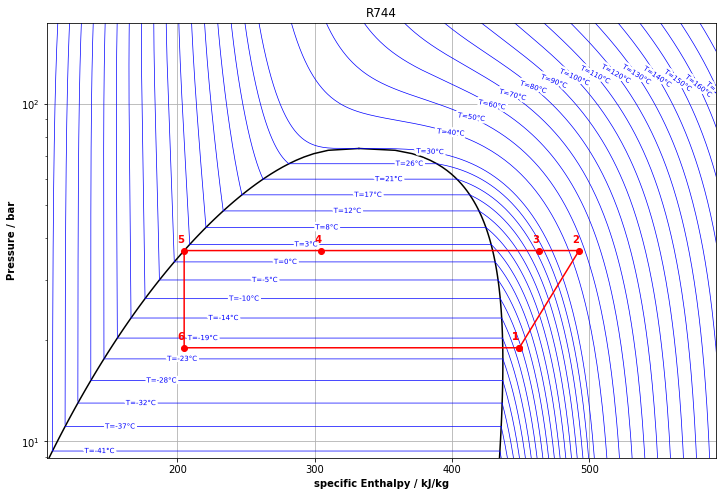

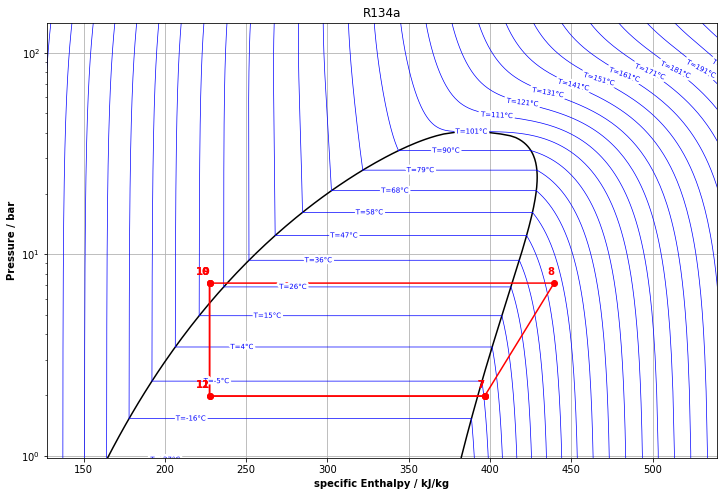

Junction 1:  p = 18.94 bar, h = 449.04 kJ/k, T = -11.264 °C, m = 0.04 kg/s
Junction 2:  p = 36.76 bar, h = 492.567 kJ/K, T = 47.316 °C, m = 0.04 kg/s
Junction 3:  p = 36.76 bar, h = 463.642 kJ/K, T = 47.316 °C, m = 0.04 kg/s
Junction 4:  p = 36.76 bar, h = 304.757 kJ/K, T = 2.028 °C, m = 0.04 kg/s
Junction 5:  p = 36.76 bar, h = 204.996 kJ/K, T = 2.028 °C, m = 0.04 kg/s
Junction 6:  p = 18.94 bar, h = 204.996 kJ/K, T = -21.264 °C, m = 0.04 kg/s
Junction 7:  p = 1.976 bar, h = 396.693 kJ/k, T = -5.375 °C, m = 0.038 kg/s
Junction 8:  p = 7.19 bar, h = 439.442 kJ/K, T = 53.129 °C, m = 0.038 kg/s
Junction 9:  p = 7.188 bar, h = 227.48 kJ/K, T = 20.0 °C, m = 0.038 kg/s
Junction 10:  p = 36.76 bar, h = 204.996 kJ/K, T = 2.028 °C, m = 0.04 kg/s
Junction 11:  p = 1.977 bar, h = 227.48 kJ/K, T = -10.368 °C, m = 0.019 kg/s
Junction 12:  p = 1.977 bar, h = 227.48 kJ/K, T = -10.368 °C, m = 0.019 kg/s


In [9]:
# resets all compontent ports
[(component.reset(), setattr(component, 'linearized', False)) for component in components]

# runs the system solver to solve system
sol = system_solver(x0, Vt, components, exec_list, res_equa, design_equa, scale_factors)

# solution vector of tearing variables
x = sol['x']

if not sol['converged']:
    print(sol['message'])
    
    # resets all compontent ports
    for c in components:
            c.reset()
else:
    # solves and exectutes all system equations and components to set all component ports by its junction value corresponding
    # to the solution
    for j, variable in enumerate(Vt):
        if variable.var_typ == 'p':
            variable.set_value(x[j] / scale_factors[0])
        elif variable.var_typ == 'h':
            variable.set_value(x[j] / scale_factors[1])
        elif variable.var_typ == 'm':
            variable.set_value(x[j] / scale_factors[2])
    for item in exec_list:
        if isinstance(item, BalanceEquation) or isinstance(item, EnthalpyFlowBalance):
            item.solve()
        elif isinstance(item, Component):
            item.solve()
            
    # junction values corresponding to the solution

    # CO2 cycle
    pi_coLT, hi_coLT, mi_coLT  = components[0].ports[0].p.value, components[0].ports[0].h.value, components[0].ports[0].m.value
    pi_gc,  hi_gc, mi_gc   = components[1].ports[0].p.value, components[1].ports[0].h.value, components[1].ports[0].m.value
    po_gc,  ho_gc, mo_gc  = components[1].ports[1].p.value, components[1].ports[1].h.value, components[1].ports[1].m.value
    pi_sepLT,  hi_sepLT, mi_sepLT   = components[4].ports[0].p.value, components[4].ports[0].h.value, components[4].ports[0].m.value
    po_sepLT,  ho_sepLT, mo_sepLT   = components[4].ports[1].p.value, components[4].ports[1].h.value, components[4].ports[1].m.value
    po_ev1,  ho_ev1, mo_ev1   = components[5].ports[1].p.value, components[5].ports[1].h.value, components[5].ports[1].m.value
    Ti_coLT = PropsSI('T', 'P', pi_coLT, 'H', hi_coLT, fluid_list[0]) - 273.15
    Ti_gc  = PropsSI('T', 'P', pi_gc, 'H', hi_gc, fluid_list[0]) - 273.15
    To_gc  = PropsSI('T', 'P', pi_gc, 'H', hi_gc, fluid_list[0]) - 273.15
    Ti_sepLT = PropsSI('T', 'P', pi_sepLT, 'H', hi_sepLT, fluid_list[0]) - 273.15
    To_sepLT  = PropsSI('T', 'P', po_sepLT, 'H', ho_sepLT, fluid_list[0]) - 273.15
    To_ev1  = PropsSI('T', 'P', po_ev1, 'H', ho_ev1, fluid_list[0]) - 273.15

    # R134a cycle
    pi_coHT, hi_coHT, mi_coHT = components[7].ports[0].p.value, components[7].ports[0].h.value, components[7].ports[0].m.value
    pi_c,  hi_c, mi_c = components[8].ports[0].p.value, components[8].ports[0].h.value, components[8].ports[0].m.value
    pi_sepHT,  hi_sepHT, mi_sepHT = components[9].ports[0].p.value, components[9].ports[0].h.value, components[9].ports[0].m.value
    po_sepHT,  ho_sepHT, mo_sepHT  = components[9].ports[1].p.value, components[9].ports[1].h.value, components[9].ports[1].m.value
    po_ev2,  ho_ev2, mo_ev2 = components[10].ports[1].p.value, components[10].ports[1].h.value, components[10].ports[1].m.value
    po_ev3,  ho_ev3, mo_ev3 = components[10].ports[1].p.value, components[10].ports[1].h.value, components[10].ports[1].m.value
    Ti_coHT = PropsSI('T', 'P', pi_coHT, 'H', hi_coHT, fluid_list[1]) - 273.15
    Ti_c  = PropsSI('T', 'P', pi_c, 'H', hi_c, fluid_list[1]) - 273.15
    Ti_sepHT = PropsSI('T', 'P', pi_sepHT, 'H', hi_sepHT, fluid_list[1]) - 273.15
    To_sepHT  = PropsSI('T', 'P', po_sepHT, 'H', ho_sepHT, fluid_list[1]) - 273.15
    To_ev2  = PropsSI('T', 'P', po_ev2, 'H', ho_ev2, fluid_list[1]) - 273.15
    To_ev3  = PropsSI('T', 'P', po_ev3, 'H', ho_ev3, fluid_list[1]) - 273.15


    # plots log ph diagramm
    
    logph([[hi_coLT * 1e-3, hi_gc * 1e-3, ho_gc * 1e-3, hi_sepLT * 1e-3, ho_sepLT * 1e-3, ho_ev1 * 1e-3, hi_coLT * 1e-3],
       [[hi_coHT * 1e-3, hi_c * 1e-3, hi_sepHT * 1e-3, ho_sepHT * 1e-3, ho_ev2 * 1e-3, hi_coHT * 1e-3], [ho_sepHT * 1e-3, ho_ev3 * 1e-3, hi_coHT * 1e-3]]],
       [[pi_coLT * 1e-5, pi_gc * 1e-5, po_gc * 1e-5, pi_sepLT * 1e-5, po_sepLT * 1e-5, po_ev1 * 1e-5, pi_coLT * 1e-5],
       [[pi_coHT * 1e-5, pi_c * 1e-5, pi_sepHT * 1e-5, po_sepHT * 1e-5, po_ev2 * 1e-5, pi_coHT * 1e-5], [po_sepHT * 1e-5, po_ev3 * 1e-5, pi_coHT * 1e-5]]],
       [[1, 2, 3, 4, 5, 6, 1], [[7, 8, 9, 10, 11, 7], [10, 12, 7]]],
       [fluid_list[0], fluid_list[1]])

    print(f'Junction 1:  p = {round(pi_coLT/1e5, 3)} bar, h = {round(hi_coLT/1e3, 3)} kJ/k, T = {round(Ti_coLT, 3)} °C, m = {round(mi_coLT, 3)} kg/s')
    print(f'Junction 2:  p = {round(pi_gc/1e5, 3)} bar, h = {round(hi_gc/1e3, 3)} kJ/K, T = {round(Ti_gc, 3)} °C, m = {round(mi_gc, 3)} kg/s')
    print(f'Junction 3:  p = {round(po_gc/1e5, 3)} bar, h = {round(ho_gc/1e3, 3)} kJ/K, T = {round(To_gc, 3)} °C, m = {round(mo_gc, 3)} kg/s')
    print(f'Junction 4:  p = {round(pi_sepLT/1e5, 3)} bar, h = {round(hi_sepLT/1e3, 3)} kJ/K, T = {round(Ti_sepLT, 3)} °C, m = {round(mi_sepLT, 3)} kg/s')
    print(f'Junction 5:  p = {round(po_sepLT/1e5, 3)} bar, h = {round(ho_sepLT/1e3, 3)} kJ/K, T = {round(To_sepLT, 3)} °C, m = {round(mo_sepLT, 3)} kg/s')
    print(f'Junction 6:  p = {round(po_ev1/1e5, 3)} bar, h = {round(ho_ev1/1e3, 3)} kJ/K, T = {round(To_ev1, 3)} °C, m = {round(mo_ev1, 3)} kg/s')

    print(f'Junction 7:  p = {round(pi_coHT/1e5, 3)} bar, h = {round(hi_coHT/1e3, 3)} kJ/k, T = {round(Ti_coHT, 3)} °C, m = {round(mi_coHT, 3)} kg/s')
    print(f'Junction 8:  p = {round(pi_c/1e5, 3)} bar, h = {round(hi_c/1e3, 3)} kJ/K, T = {round(Ti_c, 3)} °C, m = {round(mi_c, 3)} kg/s')
    print(f'Junction 9:  p = {round(pi_sepHT/1e5, 3)} bar, h = {round(hi_sepHT/1e3, 3)} kJ/K, T = {round(Ti_sepHT, 3)} °C, m = {round(mi_sepHT, 3)} kg/s')
    print(f'Junction 10:  p = {round(po_sepLT/1e5, 3)} bar, h = {round(ho_sepLT/1e3, 3)} kJ/K, T = {round(To_sepLT, 3)} °C, m = {round(mo_sepLT, 3)} kg/s')
    print(f'Junction 11:  p = {round(po_ev2/1e5, 3)} bar, h = {round(ho_ev2/1e3, 3)} kJ/K, T = {round(To_ev2, 3)} °C, m = {round(mo_ev2, 3)} kg/s')
    print(f'Junction 12:  p = {round(po_ev3/1e5, 3)} bar, h = {round(ho_ev3/1e3, 3)} kJ/K, T = {round(To_ev3, 3)} °C, m = {round(mo_ev3, 3)} kg/s')

# Bibliography

|   |   |
|---|---|
| \[1\] | Mirco Ganz. "Numerical modeling and analysis of an adaptive refrigeration cycle simulator", Master thesis, Institute of Energy Systems and Fluid Engineering IEFE, Zurich University of Applied Science, Zurich, 2023
| \[1\] |Bitzer Software 6.17.9 (2013) BITZER SOFTWARE. Available at: https://www.bitzer.de/ch/de/tools-archiv/software/software/versionen-software.jsp (Accessed:January 25, 2023).|
| \[2\] | Ian H. Bell, Sylvain Quoilin, Emeline Georges, James E. Braun, Eckhard A. Groll,W. Travis Horton, and Vincent Lemort. A generalized moving-boundary algorithm to predict the heat transfer rate of counterflow heat exchangers for any phase configuration. Applied Thermal Engineering, 79:192–201, 2015. DOI: https://doi.org/10.1016/j.applthermaleng.2014.12.028
| \[3\] | Giovanni A. Longo. Refrigerant R134a condensation heat transfer and pressure drop inside a small brazed plate heat exchanger. International Journal of Refrigeration, 31(5):780–789, 2008. https://doi.org/10.1016/j.ijrefrig.2007.11.017 |
| \[4\] |Radia Eldeeb, Vikrant Aute, and Reinhard Radermacher. A survey of correlations for heat transfer and pressure drop for evaporation and condensation in plate heat exchangers. International Journal of Refrigeration, 65:12–26, 2016. https://doi.org/10.1016/j.ijrefrig.2015.11.013|
| \[5\] | Zhenhao Chu and Wenping Zhang. Moving-boundary and finite volume coupling algorithm for heat exchanger with fluid phase change. International Journal of Heat and Mass Transfer, 131:313–328, 2019. https://doi.org/10.1016/j.ijheatmasstransfer.2018.11.066|